In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy.stats as stats
import seaborn as sns
import ast
from scipy.stats import ttest_ind, levene, shapiro, mannwhitneyu, ttest_1samp
from statsmodels.stats.proportion import binom_test

In [2]:
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())
folder_path = '/project/3024020.02/data/extracted_20250301/raw'

/home/control/yimzha/Documents/RLWM/Preprocessing
/home/control/yimzha/Documents


In [3]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300,
    'legend.fontsize': 10,
    'legend.loc': 'lower right',
    'legend.frameon': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
})

## Preprocessing

In [4]:
# Read keys for PD patients
with open("/project/3024020.02/data/keys/keysPD.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove the first row and extract the first UUID for each row
uuids_pd = [line.split()[0] for line in lines[1:] if line.strip()]
print(len(uuids_pd))
print(uuids_pd[-1])

# Read keys for HC
with open("/project/3024020.02/data/keys/keysHC_nocarriers.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove the first row and extract the first UUID for each row
uuids_hc = [line.split()[0] for line in lines[1:] if line.strip()]
print(len(uuids_hc))
print(uuids_hc[-1])

7493
a6de0850-bb24-47ae-867d-6724bccee7b6
2490
b709847d-edc1-4918-a4be-f9317b714bd7


### RLWM

In [5]:
# Get a list of all CSV files in the folder with "RLWM"
all_rlwm_files = glob.glob(os.path.join(folder_path, "RLWM_*.csv"))
csv_files_pd = [
    f for f in all_rlwm_files
    if any(uuid in os.path.basename(f) for uuid in uuids_pd)
]
csv_files_hc = [
    f for f in all_rlwm_files
    if any(uuid in os.path.basename(f) for uuid in uuids_hc)
]
print(f'N for all = {len(all_rlwm_files)}')
print(f'N for PD = {len(csv_files_pd)}')
print(f'N for HC = {len(csv_files_hc)}')

N for all = 284
N for PD = 199
N for HC = 45


In [7]:
new_df_combined = pd.DataFrame()

for i, csv_file in enumerate(csv_files_pd):
    df = pd.read_csv(csv_file)

    # Get uuid
    filename = os.path.basename(csv_file)
    matched_uuid = [uuid for uuid in uuids_pd if uuid in filename][0]

    # Filter rows where 'trial_mode' is 'learning'
    df = df.loc[df['trial_mode'] == 'learning']
    if df.empty:
        print(f"Empty after learning filter: {matched_uuid} ({filename})")
        
    # Remove "blockId" column
    df = df.drop(columns=['blockId'])
    # Create block number - block incremented by 1 for each new setId / setSize
    df['block'] = ((df['setId'] != df['setId'].shift()) | (df['setSize'] != df['setSize'].shift())).cumsum() - 1
    # Rename stimId based on block and setsize
    df['stimseq'] = df.groupby('block')['stimId'].transform(lambda x: pd.factorize(x)[0]) + 1
    # Calculate iteration numbers
    df['iterseq'] = df.groupby(['block', 'stimId']).cumcount() + 1

    # Calculate delays for previous correct trials
    # Get the previous "correct" = 1 index (excluding current row)
    df['prev_correct_index'] = (
        df.groupby(['block', 'stimseq'])['correct']
        .transform(lambda x: x.index.to_series().where(x == 1).shift(1).ffill())
    )
    # Calculate delay and replace NaNs with -1
    df['delay'] = (df.index - df['prev_correct_index']).fillna(-1)

    # Calculate leanring stages based on numbers of previous correct trials
    # This "pcor" does not include the current trial, so if the current trial is the first correct trial per stimulus,
    # The "pcor" of the current trial will be 0
    df['good'] = (df['correct'] == 1).astype('int8')
    df['pcor'] = (
        df['good']  
        .groupby([df['block'], df['stimseq']])
        .cumsum()                             
        .sub(df['good'])                      
    )
    # First 0-2 correct trials are assigned 0 (early learning)
    # Last 2 trials are assigned 1 (late learning)
    # Calculate maximum pcor
    max_pcor = df.groupby(['block', 'stimseq'])['pcor'].transform('max')
    df['learning'] = np.nan
    # Early learning
    df.loc[df['pcor'].isin([1, 2, 3]), 'learning'] = 0
    # Late learning
    df.loc[df['pcor'].isin([8, 9]), 'learning'] = 1
    #df.loc[(df['pcor'] == max_pcor) | (df['pcor'] == (max_pcor - 1)), 'learning'] = 2
    df['learning'] = df['learning'].fillna(-1).astype(int)

    # Calculate number of times this action was previously chosen - starting from 0
    df['pchos'] = (df.groupby(['block', 'stimseq', 'key_response']).cumcount())

    # Create a key column - who knows what this is..
    df['key'] = df['key_response']
    # Create a reward column - who knows what this is..
    df['rew'] = df['correct']
    # Create a expe_condition column - who knows what this is..
    df['expe_condition'] = 1
    # Randomly add a time column - who knows what this is..
    df['time'] = 0
    # Create a correct action column
    # coraseq = -1 means that we don't know the correct action because of lack of information
    df['coraseq'] = df['key_response'].where(df['correct'] == 1)
    df['coraseq'] = df.groupby(['block', 'stimseq'])['coraseq'].transform('first')
    df['coraseq'] = df['coraseq'].fillna(-1).astype(int)

    # Select specific columns from df
    selected_columns = df[['block', 'setSize', 'time', 'stimseq', 'stimId', 'setId', 'iterseq', 
                           'coraseq', 'key_response', 'key', 'correct', 
                           'rew', 'rt', 'expe_condition', 
                           'pcor', 'delay', 'pchos', 'learning']]
    # Rename the columns
    new_df = selected_columns.rename(columns={
        'setSize': 'ns',
        'stimId': 'imageseq',
        'setId': 'folderseq',
        'key_response': 'choice'
    }).astype(int)
    # Insert subjectID at the first position
    new_df.insert(0, 'subno', matched_uuid)

    # Concatenate data for each participant into one df
    new_df_combined = pd.concat([new_df_combined, new_df], ignore_index=True)

new_df_combined.to_csv(f'sorted_pd.csv', index=False)

# Descriptions about new_df structure
# 1. subno - subject ID
# 2. block - block number
# 3. ns - set size, the number of stimuli in each block
# 4. time - tbd
# 5. stimseq - stimulus id (transform real stimID to match setsize limit)
# 6. imageseq - actual image number
# 6. folderseq - image category number
# 8. iterseq - iteration number per stimulus, ranging from 1 to 10 for each stimulus
# 9. coraseq - correct action - tbd
# 10. choice - actual action 
# 11. key - physical key pressed - tbd
# 12. correct - correctness (1 correct, o incorrect, -1 no response)
# 13. rew - reward - tbd
# 14. rt - reaction time
# 15. expe condition - experimental condition (for some data sets) - set to 1 - tbd
# 16. pcor - the number of [previous(!)] correct responses for each stimulus
# 17. delay - the trial interval since the current stimulus was last reinforced (delay) - is -1 when no correct previous response
# 18. pchos - number of times this action was previously chosen
# 19. learning - learning stage (First 0-2 correct trials are assigned 1 (early learning) Last 2 trials are assigned 2 (late learning))

### Preprocessing

In [9]:
df = pd.read_csv('sorted_hc.csv')
# Count sample size
n_subj = df['subno'].nunique()
print(f'Number of all participants: {n_subj}')
print('-----------------------------------------')

# 1. Remove the first block for every participant (training block)
df = df[df['block'] != 0]

# 2. Calculate non-response rate & remove participants
proportions_1 = df.groupby('subno')['correct'].apply(lambda x: (x == -1).mean()).reset_index(name='proportion')
mean_prop = proportions_1['proportion'].mean()
std_prop = proportions_1['proportion'].std()
print(f"Proportion with no response rate: Mean = {mean_prop:.2%}, SD = {std_prop:.2}")

subno_to_remove = proportions_1[proportions_1['proportion'] >= 0.2]['subno']
df = df[~df['subno'].isin(subno_to_remove)]
print(f'Number of participants removed based on non response rate: N = {len(subno_to_remove)}')
print('-----------------------------------------')

# 3. Drop blocks where proportions of no responses exceed the cut-off
# Count, for each participant, how many blocks were removed (i.e. condition is False)
cut_off = 0.2
block_condition = df.groupby(['subno', 'block'])['correct'].apply(
    lambda x: (x == -1).mean() <= cut_off
)
removed_blocks = block_condition.groupby('subno').apply(lambda x: (~x).sum())
print(f"Number of blocks removed per participant: Mean = {removed_blocks.mean():.2}, SD = {removed_blocks.std():.2}")

proportion_filter = df.groupby(['subno', 'block'])['correct'].transform(lambda x: (x == -1).mean() <= cut_off)
df = df[proportion_filter]
print('-----------------------------------------')

# 4. Remove trials with no response
removed_trials = df.groupby('subno')['correct'].apply(lambda x: (x == -1).mean())
print(f"Proportion of trials removed per participant: Mean = {removed_trials.mean():.2}, SD = {removed_trials.std():.2}")
df = df[df['correct'] != -1]
print('-----------------------------------------')

# 5. Remove trials where RT < 200ms
df = df[df['rt'] > 200]

# 6. Remove participants based on accuracy
def get_cutoff(n_trials, guess_prob=1/3, alpha=0.05):
    """
    Given the number of trials and the probability of guessing, what is the cut-off for significantly higher than guessing?
    """
    for k in range(n_trials):
        p_val = binom_test(k, n_trials, guess_prob, alternative='larger')
        if p_val < alpha:
            cutoff_rate = k / n_trials
            return cutoff_rate
    return None

grouped = df.groupby(['subno', 'ns'])['correct'].mean().reset_index()
check_df = grouped.pivot(index='subno', columns='ns', values='correct').reset_index()

check_df.columns.name = None

# ns == 2 or 3
cond1 = df[df['ns'].isin([2, 3])]
avg_2_3 = cond1.groupby('subno')['correct'].mean().reset_index()
avg_2_3.rename(columns={'correct': 'avg_ns_2_3'}, inplace=True)

# ns == 4 or 5
cond2 = df[df['ns'].isin([4, 5])]
avg_4_5 = cond2.groupby('subno')['correct'].mean().reset_index()
avg_4_5.rename(columns={'correct': 'avg_ns_4_5'}, inplace=True)

# Overall
overall = df.groupby('subno')['correct'].mean().reset_index()
overall.rename(columns={'correct': 'avg_all'}, inplace=True)

# Integrate to check_df
check_df = check_df.merge(avg_2_3, on='subno', how='left')
check_df = check_df.merge(avg_4_5, on='subno', how='left')
check_df = check_df.merge(overall, on='subno', how='left')

remove = check_df[check_df['avg_all'] < get_cutoff(n_trials=360)]
print(f"Accuracy cut-off: {get_cutoff(n_trials=360):.2%}")

df = df[~df['subno'].isin(remove['subno'])]

n_subj = df['subno'].nunique()
print(f'Number of all participants: {n_subj}')
df.to_csv(f'clean_hc.csv', index=False)

Number of all participants: 44
-----------------------------------------
Proportion with no response rate: Mean = 4.39%, SD = 0.036
Number of participants removed based on non response rate: N = 0
-----------------------------------------
Number of blocks removed per participant: Mean = 0.14, SD = 0.35


-----------------------------------------
Proportion of trials removed per participant: Mean = 0.042, SD = 0.033
-----------------------------------------
Accuracy cut-off: 37.78%
Number of all participants: 44


In [10]:
df = pd.read_csv('clean_pd.csv')

# Get all UUIDs
subno_unique_list = df['subno'].unique().tolist()
n_subj = df['subno'].nunique()
print(f'Number of participants after preprocessing: {n_subj}')

# In case we lose something...
ori_df = df

Number of participants after preprocessing: 171


### Group comparison

In [87]:
# Main effect of group on accuracy
hc_df = pd.read_csv('clean_all_hc.csv')
pd_df = pd.read_csv('clean_all.csv')
hc_df = hc_df[hc_df['pcor'] != 0]
pd_df = pd_df[pd_df['pcor'] != 0]

pd_acc = pd_df.groupby('subno')['correct'].mean().reset_index()['correct']
hc_acc = hc_df.groupby('subno')['correct'].mean().reset_index()['correct']

# t test
_, p_high = shapiro(pd_acc)
_, p_low = shapiro(hc_acc)
_, p_var = levene(pd_acc, hc_acc)
normal = (p_high > 0.05) and (p_low > 0.05)
equal_var = (p_var > 0.05)
print(p_high, p_low, p_var)

if normal:
    if equal_var:
        # Independent sample t test
        t_stat, p_value = ttest_ind(pd_acc, hc_acc, equal_var=True)
    else:
        # Welch's t test
        t_stat, p_value = ttest_ind(pd_acc, hc_acc, equal_var=False)
    test_used = "Independent sample t test" if equal_var else "Welch's t test"
else:
    # Mannwhitney U
    u_stat, p_value = mannwhitneyu(pd_acc, hc_acc, alternative='two-sided')
    test_used = "Mannwhitney U"

print(f"Test used: {test_used}, p = {p_value:.4f}")
t_stat, p_value = ttest_ind(pd_acc, hc_acc, equal_var=True)
print(f'Let us just assume all assumptions of t test are met, then p = {p_value}')

0.00010645846224370598 0.016717213416642077 0.5334076028956869
Test used: Mannwhitney U, p = 0.0083
Let us just assume all assumptions of t test are met, then p = 0.009391852124478742


### Medication status

MDSUPDRS

Notes: 
1. "choice" is MDSUPDRS score
2. total MDSUPDRS score: choice - 1 and sum up
3. <12 = mild, >30 severe

Caution:
1. some MDSUPDRS files are empty
2. Fewer MDSUPDRS files than RLWM data

In [11]:
# MDSUPDRS (some files are empty so.....)
# Initialize dictionary to store results
uuid_sums = {}

# Get a list of all CSV files in the folder with "questionnaires_MDSUPDRS_"
all_mds_files = glob.glob(os.path.join(folder_path, "questionnaires_MDSUPDRS_*.csv"))
print(f"N (all PD patients with MDSUPDRS scores) = {len(all_mds_files)}")

for csv_file in all_mds_files:
    # Extract filename and check against uuids
    filename = os.path.basename(csv_file)
    matched_uuids = [uuid for uuid in subno_unique_list if uuid in filename]
    
    if not matched_uuids:
        continue  # Skip files without matching UUID
    
    # Process the matching UUID
    uuid = matched_uuids[0]
    
    # Process CSV and calculate sum
    df = pd.read_csv(csv_file)

    if "choice" not in df.columns:
        print(f"Warning csv {filename} does not have a choice column and was skipped")
        continue
    
    df["choice"] = df["choice"] - 1
    total_sum = df["choice"].sum()
    
    # Store result in dictionary
    uuid_sums[uuid] = total_sum

print(f"N (PD patients with MDSUPDRS scores & matched preprocessed RLWM data) = {len(uuid_sums)}")

N (all PD patients with MDSUPDRS scores) = 220
Warning csv questionnaires_MDSUPDRS_1f5b6a6f-1101-4c25-876a-ee4a419e1d98.csv does not have a choice column and was skipped
Warning csv questionnaires_MDSUPDRS_bcf1cdf2-27c1-4cd1-af7f-c52a2d687ae8.csv does not have a choice column and was skipped
N (PD patients with MDSUPDRS scores & matched preprocessed RLWM data) = 137


Mean = 16.124087591240876, SD = 8.002230761494634


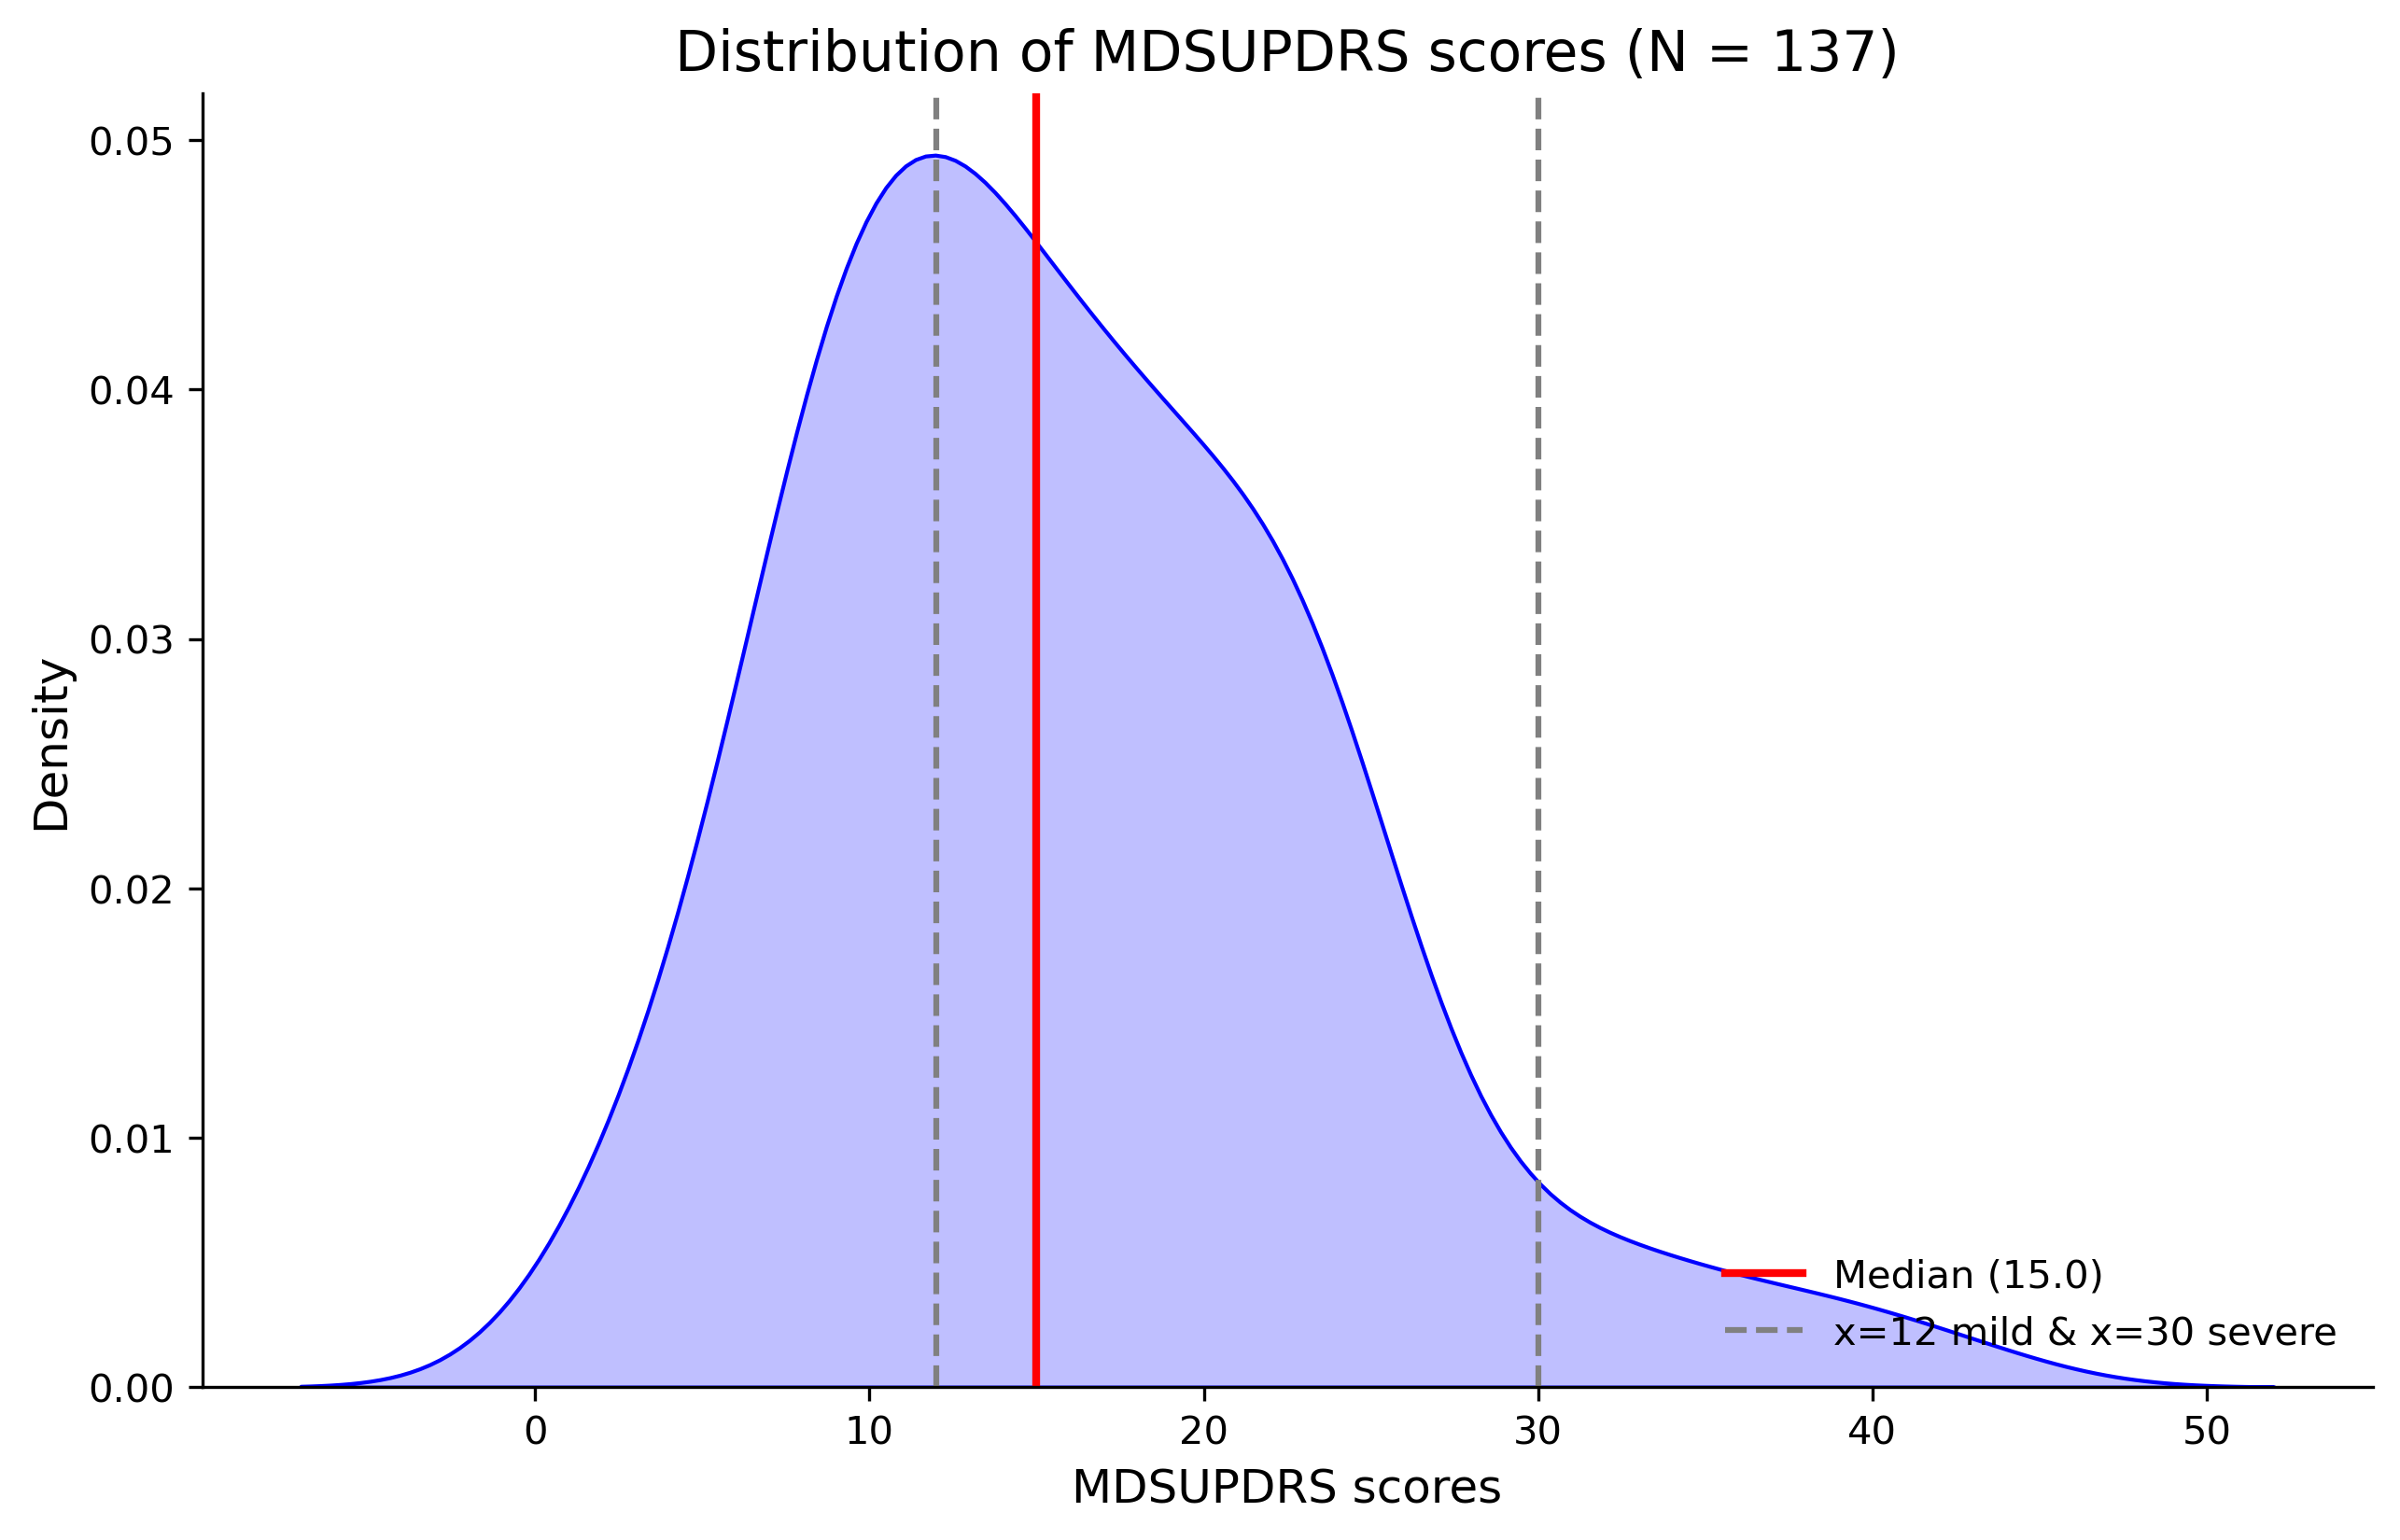

In [12]:
data_mds = np.array(list(uuid_sums.values()))
print(f'Mean = {data_mds.mean()}, SD = {data_mds.std()}')

plt.figure(figsize=(10, 6))
sns.kdeplot(data_mds, fill=True, color='blue')

median = np.median(data_mds)
plt.axvline(median, color='red', linewidth=2, label=f'Median ({median:.1f})')
plt.axvline(12, color='gray', linestyle='--', linewidth=1.5, label='x=12 mild & x=30 severe')
plt.axvline(30, color='gray', linestyle='--', linewidth=1.5)

plt.title(f'Distribution of MDSUPDRS scores (N = {len(uuid_sums)})')
plt.xlabel('MDSUPDRS scores')
plt.ylabel('Density')
plt.legend()
plt.show()

Subjective scales (motor & cognitive)

In [13]:
# Med data for RLWM
# Initialize dictionary to store results
uuid_motor_RLWM = {}
uuid_cog_RLWM = {}

# Get a list of all CSV files in the folder with "questionnaires_MDSUPDRS_"
all_med_files_RLWM = glob.glob(os.path.join(folder_path, "MEDdata_RLWM*.csv"))
print(f"N (all PD patients with MED RLWM data) = {len(all_med_files_RLWM)}")

for csv_file in all_med_files_RLWM:
    # Extract filename and check against uuids
    filename = os.path.basename(csv_file)
    matched_uuids = [uuid for uuid in subno_unique_list if uuid in filename]
    
    if not matched_uuids:
        continue  # Skip files without matching UUID
    
    # Process the matching UUID
    uuid = matched_uuids[0]
    
    # Process CSV
    df = pd.read_csv(csv_file)
    df["response"] = df["response"].apply(ast.literal_eval)
    motor_med = df["response"].apply(lambda x: x["motorMed"])
    cog_med = df["response"].apply(lambda x: x["cognitiveMed"])
    uuid_motor_RLWM[uuid] = int(motor_med[0])
    uuid_cog_RLWM[uuid] = int(cog_med[0])

print(f"N (PD patients with Med_RLWM scores & matched preprocessed RLWM data) = {len(uuid_cog_RLWM)}")

N (all PD patients with MED RLWM data) = 283
N (PD patients with Med_RLWM scores & matched preprocessed RLWM data) = 171


In [14]:
# Med data for PAL
# Initialize dictionary to store results
uuid_motor_PAL = {}
uuid_cog_PAL = {}

# Get a list of all CSV files in the folder with "questionnaires_MDSUPDRS_"
all_med_files_PAL = glob.glob(os.path.join(folder_path, "MEDdata_PAL*.csv"))
print(f"N (all PD patients with MED PAL data) = {len(all_med_files_PAL)}")

for csv_file in all_med_files_PAL:
    # Extract filename and check against uuids
    filename = os.path.basename(csv_file)
    matched_uuids = [uuid for uuid in subno_unique_list if uuid in filename]
    
    if not matched_uuids:
        continue  # Skip files without matching UUID
    
    # Process the matching UUID
    uuid = matched_uuids[0]
    
    # Process CSV
    df = pd.read_csv(csv_file)
    df["response"] = df["response"].apply(ast.literal_eval)
    motor_med = df["response"].apply(lambda x: x["motorMed"])
    cog_med = df["response"].apply(lambda x: x["cognitiveMed"])
    uuid_motor_PAL[uuid] = int(motor_med[0])
    uuid_cog_PAL[uuid] = int(cog_med[0])

print(f"N (PD patients with Med_PAL scores & matched preprocessed RLWM data) = {len(uuid_cog_PAL)}")

N (all PD patients with MED PAL data) = 316


N (PD patients with Med_PAL scores & matched preprocessed RLWM data) = 170


### Save data

In [15]:
df = ori_df
df['mds'] = df['subno'].map(uuid_sums)
df['med_motor_RLWM'] = df['subno'].map(uuid_motor_RLWM)
df['med_cog_RLWM'] = df['subno'].map(uuid_cog_RLWM)
df['med_motor_PAL'] = df['subno'].map(uuid_motor_PAL)
df['med_cog_PAL'] = df['subno'].map(uuid_cog_PAL)

df.to_csv(f'clean_pd_mds_med.csv', index=False)